In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFile



In [6]:
train_dir = r'P:\Risk Realm\Artificial Intelligence\Project\dataset\train'
val_dir=r'P:\Risk Realm\Artificial Intelligence\Project\dataset\val'
test_dir=r'P:\Risk Realm\Artificial Intelligence\Project\dataset\testing'


In [7]:
print(train_dir)

P:\Risk Realm\Artificial Intelligence\Project\dataset\train


In [8]:
img_height,img_width=224,224
batch_size=16

def apply_clahe(image):
    # Convert image from float (0-1) to uint8 (0-255)
    image = (image * 255).astype(np.uint8)
    
    # Apply CLAHE to each channel (for RGB images)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    image = cv2.merge(clahe_channels)
    
    # Normalize the image to make min value 0 and max value 1
    image = image.astype(np.float32)
    min_val = image.min()
    max_val = image.max()
    
    # Avoid division by zero
    if max_val - min_val != 0:
        image = (image - min_val) / (max_val - min_val)
    
    return image

train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe
)

# Load training dataset with augmentation
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',        # Binary classification
    seed=123
)
test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)
test_ds=test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',        # Binary classification
    seed=123
)
val_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)  # Note the absence of augmentation
val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',    
    seed=123
)

Found 8683 images belonging to 2 classes.
Found 175 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [9]:
class_names = train_ds.class_indices
print(class_names)

{'fractured': 0, 'not fractured': 1}


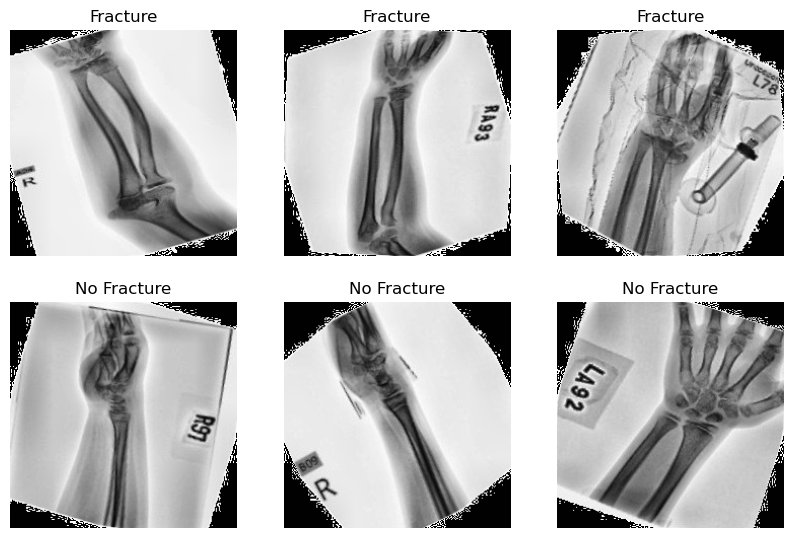

In [10]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_ds)

# Initialize counters for each class
fracture_count = 0
no_fracture_count = 0

# List to store selected images and labels
selected_images = []
selected_labels = []

# Loop through the batch to select 3 images of each class
for img, label in zip(images, labels):
    if label == 1 and fracture_count < 3:
        selected_images.append(img)
        selected_labels.append(label)
        fracture_count += 1
    elif label == 0 and no_fracture_count < 3:
        selected_images.append(img)
        selected_labels.append(label)
        no_fracture_count += 1
    
    # Stop if we have 3 of each class
    if fracture_count == 3 and no_fracture_count == 3:
        break

# Plot the selected images
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(selected_images[i])
    plt.title("Fracture" if selected_labels[i] == 0 else "No Fracture")
    plt.axis("off")

plt.show()


In [11]:

images, labels = next(train_ds)


min_val = images.min()
max_val = images.max()

print(f"Minimum pixel value: {min_val}")
print(f"Maximum pixel value: {max_val}")


Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [12]:
densenet_model = Sequential()


pretrained_model = DenseNet121(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)


for layer in pretrained_model.layers:
    layer.trainable = False


densenet_model.add(pretrained_model)
densenet_model.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(1, activation='sigmoid'))  


In [13]:
densenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,562,817 (28.85 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [14]:
for layer in pretrained_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True


densenet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:


history = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50


c:\Dev_Dynasty\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


543/543 ━━━━━━━━━━━━━━━━━━━━ 324s 577ms/step - accuracy: 0.5451 - loss: 1.4183 - val_accuracy: 0.7600 - val_loss: 1.1479
Epoch 2/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 298s 549ms/step - accuracy: 0.6680 - loss: 1.2075 - val_accuracy: 0.7217 - val_loss: 1.0658
Epoch 3/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 294s 542ms/step - accuracy: 0.7391 - loss: 1.0589 - val_accuracy: 0.7200 - val_loss: 0.9967
Epoch 4/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 290s 535ms/step - accuracy: 0.8076 - loss: 0.9179 - val_accuracy: 0.7000 - val_loss: 0.9701
Epoch 5/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 295s 544ms/step - accuracy: 0.8553 - loss: 0.7928 - val_accuracy: 0.6750 - val_loss: 0.9732
Epoch 6/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 345s 635ms/step - accuracy: 0.9121 - loss: 0.6692 - val_accuracy: 0.6550 - val_loss: 1.0125
Epoch 7/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 374s 689ms/step - accuracy: 0.9377 - loss: 0.5817 - val_accuracy: 0.6933 - val_loss: 1.0043
Epoch 8/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 410s 755ms/step - accuracy: 0.9565 - loss: 0.51

In [21]:
import pickle

# Save the training history
with open('DenseNet(50).pkl', 'wb') as file:
    pickle.dump(history.history, file)


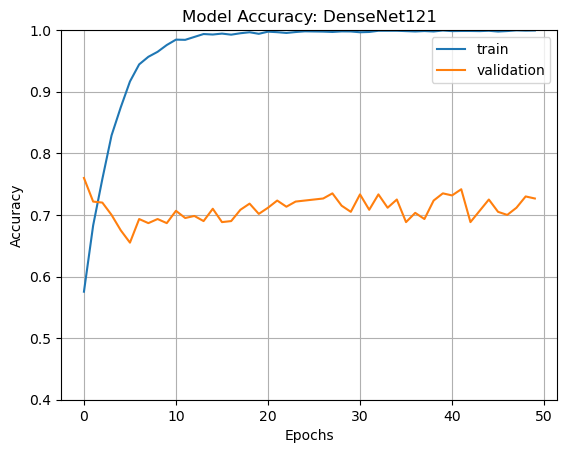

In [22]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy: DenseNet121')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

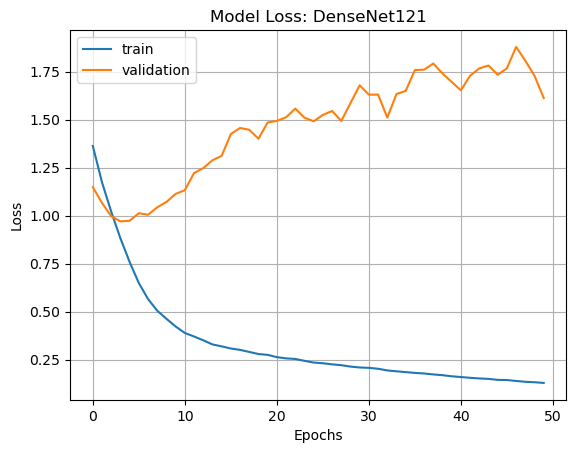

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss: DenseNet121')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 842ms/step
Accuracy: 0.50
Classification Report:
                precision    recall  f1-score   support

Not Fractured       0.60      0.53      0.56       360
    Fractured       0.40      0.46      0.43       240

     accuracy                           0.50       600
    macro avg       0.50      0.50      0.49       600
 weighted avg       0.52      0.50      0.51       600

Confusion Matrix:
 [[191 169]
 [129 111]]


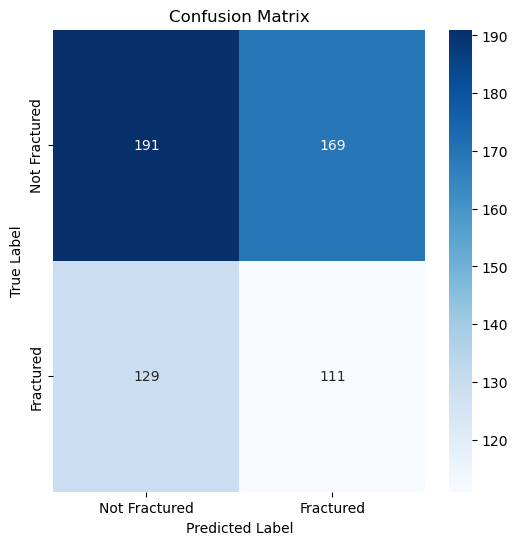

In [19]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on test set
val_preds = densenet_model.predict(val_ds)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary classes (0 or 1)

# Get the true labels from the test set
val_labels = np.concatenate([val_ds[i][1] for i in range(len(val_ds))])

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_preds)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
target_names = ['Not Fractured', 'Fractured']
report = classification_report(val_labels, val_preds, target_names=target_names)
print("Classification Report:\n", report)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [20]:
# Save the model in the SavedModel format
densenet_model.save('densenet_model(50).keras')
